In [45]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf

In [46]:
# Load the palmer_penguins_5000.csv dataframe
df_penguins = pd.read_csv('palmer_penguins_5000.csv')
print(df_penguins.head())

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  


In [47]:
df_penguins['sex_int'] = df_penguins['sex'].map({'Female': 0, 'Male': 1})
print(df_penguins.head())

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  sex_int  
0       3750.0    Male      1.0  
1       3800.0  Female      0.0  
2       3250.0  Female      0.0  
3          NaN     NaN      NaN  
4       3450.0  Female      0.0  


In [48]:
df_penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            5000 non-null   object 
 1   island             5000 non-null   object 
 2   bill_length_mm     4967 non-null   float64
 3   bill_depth_mm      4967 non-null   float64
 4   flipper_length_mm  4967 non-null   float64
 5   body_mass_g        4967 non-null   float64
 6   sex                4836 non-null   object 
 7   sex_int            4836 non-null   float64
dtypes: float64(5), object(3)
memory usage: 312.6+ KB


In [49]:
# Print the proportion of each species in the df_penguins dataframe
print(f'''
Proportion Penguins
{((df_penguins['species'].value_counts()/len(df_penguins)).sort_values(ascending=False))}
''')



Proportion Penguins
species
Adelie       0.4418
Gentoo       0.3618
Chinstrap    0.1964
Name: count, dtype: float64



In [50]:
# Stratified Sampling Function
def data_strat(df_penguins, strat_columns_name, strat_values, prop_strat, random_state=None):
    
    df_estrat = pd.DataFrame(columns=df_penguins.columns) # Create an empty data frame with the names of the columns of df_penguins
    
    pos = -1
    for i in range(len(strat_values)): # Iterate over the input of stratified values
        pos += 1
        if pos == len(strat_values) -1:
            ratio_len = len(df_penguins) - len(df_estrat) # Calculates the number of output values having the same number of rows as input
        else:
            ratio_len = int(len(df_penguins) * prop_strat[i]) # calculates the number of rows according to the desired ratio
        
        df_filter = df_penguins[df_penguins[strat_columns_name] == strat_values[i]] # filters the source data based on the values selected in the data layer
        df_temp = df_filter.sample(replace=True, n=ratio_len, random_state=random_state) # sample the filtered data using the ratio we have calculated

        df_estrat = pd.concat([df_estrat, df_temp]) # concat the sample tables with the stratified one to produce the final result

    return df_estrat # Return the stratified, re-sampled data  

In [51]:
# Define the stratified values and proportions
strat_values = ['Adelie', 'Chinstrap', 'Gentoo']
strat_prop = [0.333, 0.333, 0.333]

# Perform stratified sampling on the penguins dataframe
df_strat = data_strat(df_penguins, 'species', strat_values, strat_prop, random_state=42)

# Print the proportion of each species in the stratified sample
print(f'''
Proportion sample penguins
{((df_strat['species'].value_counts()/len(df_strat)).sort_values(ascending=False))}
''')



Proportion sample penguins
species
Gentoo       0.334
Adelie       0.333
Chinstrap    0.333
Name: count, dtype: float64



C:\Users\Philip\AppData\Local\Temp\ipykernel_30792\4016957455.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_estrat = pd.concat([df_estrat, df_temp]) # concat the sample tables with the stratified one to produce the final result


In [52]:
# Split the data into train and test sets
train, test = train_test_split(df_penguins, train_size=0.5, random_state=1)

# Fit the logistic regression model
logit_model = smf.logit(
    formula='sex_int ~ flipper_length_mm + body_mass_g + bill_length_mm + bill_depth_mm + species + island',
    data=train
).fit()

# Predict on the test set
test_predict = logit_model.predict(test).round()


Optimization terminated successfully.
         Current function value: 0.193555
         Iterations 9


In [53]:
# Fill NaN values in test_predict with the most frequent class (mode)
test_predict = test_predict.fillna(test_predict.mode()[0])

# Fill NaN values in test.sex_int with the most frequent class (mode)
test['sex_int'] = test['sex_int'].fillna(test['sex_int'].mode()[0])

accuracy_score(
    test.sex_int,
    test_predict
)

0.8996

<Axes: title={'center': 'Confusion Matrix'}>

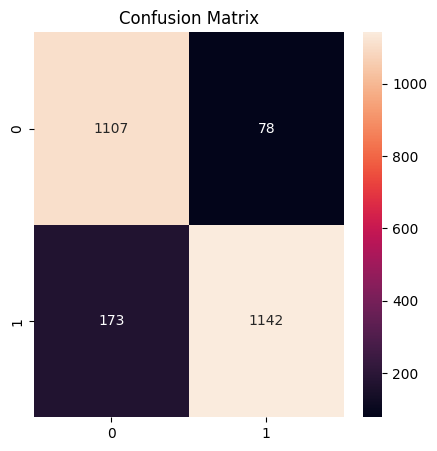

In [54]:
plt.figure(figsize=(5,5))
plt.title('Confusion Matrix')
sns.heatmap(
    confusion_matrix(test['sex_int'], test_predict),
    annot=True,
    fmt='d'
)

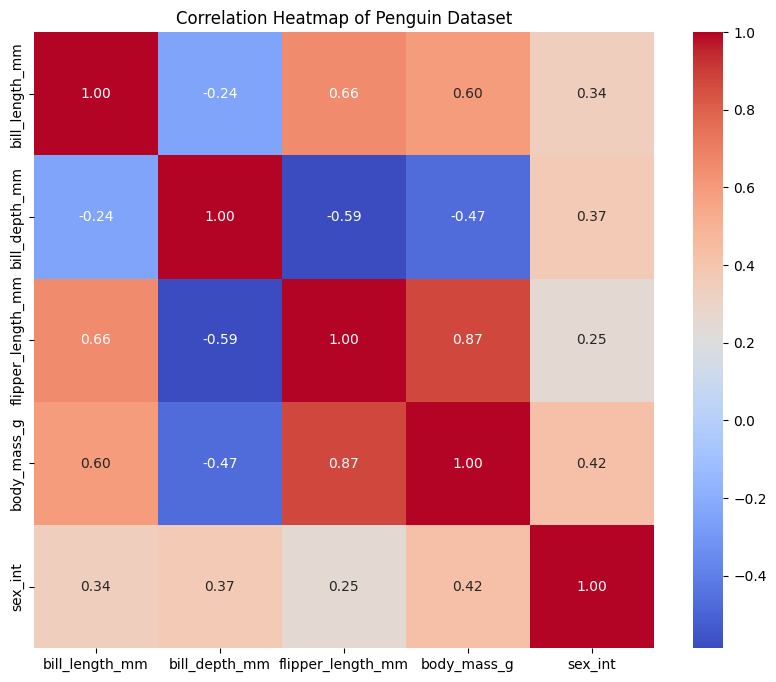

In [56]:
# Select only numeric columns for correlation matrix
numeric_df = df_penguins.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Penguin Dataset')
plt.show()